# TruthLens Data Cleaning and Exploration
The purpose of this notebook is to prepare the data for both phases for the modelling process.

## Phase 1: Real vs. Fake News Classification
The first stage leverages the Misinformation & Fake News text dataset, which contains almost 79,000 long-form articles evenly distributed between two classes: real and fake news. The dataset is well-suited for binary classification due to its balance and scale. Using an existing dataset eliminates the need for custom data collection for this phase and accelerates development.

Phase 1 preprocessing includes tokenisation, stop-word removal, and text normalisation. These steps ensure consistency and reduce noise in the input data, enabling efficient model training.

The Misinformation & Fake News text dataset has been downloaded from https://www.kaggle.com/datasets/stevenpeutz/misinformation-fake-news-text-dataset-79k

In [1]:
!pip install textacy
!pip install textstat

In [2]:
#all imports
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
import random
import nltk
import time
import csv
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk import word_tokenize, pos_tag
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer, PorterStemmer
import string
from string import punctuation
from textacy import preprocessing
import textstat
from wordcloud import WordCloud
from tqdm.notebook import tqdm
tqdm.pandas()

#settings
pd.set_option('display.max_colwidth', None)
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\hazel\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\Users\hazel\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\hazel\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\hazel\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### Load the dataset

In [3]:
input_True = 'DataSet_Misinfo_TRUE.csv'
input_Fake = 'DataSet_Misinfo_FAKE.csv'
#load each subset to a dataframe
true_df = pd.read_csv(input_True)
fake_df = pd.read_csv(input_Fake)
#add a label for each class - 0 for True and 1 for False
true_df['label'] = 0
fake_df['label'] = 1
#combine the dataframes
df = pd.concat([true_df, fake_df], ignore_index=True)
#shuffle the dataset
df = df.sample(frac=1, random_state=999).reset_index(drop=True)
#drop unnecessary columns
df = df[['text', 'label']]
#rename column
df = df.rename(columns={"text":"content"})
#drop na
df = df.dropna(subset=['content'])
#store
df.to_csv('new_data.csv', index=False)
#basic checks
print("DataFrame Info:")
df.info()
print("\nClass overview:")
print(df['label'].value_counts())

DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 78588 entries, 0 to 78616
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   content  78588 non-null  object
 1   label    78588 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 1.8+ MB

Class overview:
1    43642
0    34946
Name: label, dtype: int64


### Replace censored words
I've noticed that the data contains a lot of censored words - for example "f*ck" instead of "fuck", so I am replacing those with the uncensored versions before continuing with preprocessing.

In [4]:
def find_censored_words(dataframe, column_name):
    """
    Finds censored words in the specified column of a DataFrame, where a censored word contains one or more * e.g. f*ck.

    Parameters:
    ----------
    dataframe : pd.DataFrame
        The DataFrame containing the text data.
    column_name : str
        The name of the column to search for censored words.

    Returns:
    -------
    list
        A set of unique censored words found in the specified column.
    """
    #Regex pattern for censored words - word boundary, 1 or more alphanumeric characters on each side, 1 or more asterix.
    pattern = r'\b\w+\*+\w+\b'
    # Combine all text in the specified column
    combined_text = ' '.join(dataframe[column_name].astype(str)).lower()
    # Find all matches of the pattern
    censored_words = re.findall(pattern, combined_text)
    # Return unique matches
    return list(set(censored_words))

In [5]:
#Find censored words
start_time = time.time()
censored_words = find_censored_words(df, 'content')
print("Find censored words: {:.4f} seconds".format(time.time() - start_time))
print("Sample of censored words found:\n", ' '.join(random.sample(censored_words, 10)))

Find censored words: 33.6847 seconds
Sample of censored words found:
 motherf**ker p*ssy n*gaa themes*download warning****language sl*tshaming f*ggot news*us s*ck warning***this


In [6]:
substitutions = {
    'f*ckton':'fuckton', 'sh**tting':'shitting', 'sh*tter':'shitter', 'p****y':'pussy', 'f*ckballs':'fuckballs', 'ni**ers':'niggers', 'motherf***er':'motherfucker', 'ni***r':'nigger', 'c*m':'cum', 'f*ckups':'fuckups', 'dumbsh*t':'dumbshit', 'f***ing':'fucking','n****r':'nigger', 'sh*tty':'shitty', 'n***ers':'niggers', 'p*ssing':'pissing', 'p***ed':'pissed', 'motherf*ckers':'motherfuckers','chickensh*t':'chickenshit', 'f***er':'fucker', 'b*tches':'bitches', 'f*****g':'fucking', 'd**ks':'dicks', 'p*ssies':'pussies','n***a':'nigga', 'f*cks':'fucks', 'f**king':'fucking', 'f**ker':'fucker', 'sh*tting':'shitting', 'bulls*it':'bullshit', 's*it':'shit','f*ckface':'fuckface', 'wh*res':'whores', 'd*ick':'dick', 'sh*t':'shit', 'h*mos':'homos', 'sh*tstorm':'shitstorm', 'b*tch':'bitch','f*cking':'fucking', 's*ithead':'shithead', 'tr*mp':'trump', 'a*shole':'asshole', 'f*cker':'fucker', 'a**hole':'asshole','a*ses':'asses', 'assh*le':'asshole', 'g*damn':'goddamn', 'f*cktruck':'fucktruck', 'p***y':'pussy', 'f**k':'fuck', 'as*hole':'asshole','mother*cker':'motherfucker', 'f****ts':'faggots', 'f*g':'fag', 'g**damned':'goddamned', 'f*ckers':'fuckers', 'ratf*cking':'ratfucking','apesh**t':'apeshit', 'sh*tshow':'shitshow', 'c*ckblocking':'cockblocking', 'f*ker':'fucker', 'n**ger':'nigger', 'p*ssyhats':'pussyhats','batsh*t':'batshit', 'nostradumb*ss':'nostradumbass', 'f**cking':'fucking', 'a**es':'asses', 'n*ggers':'niggers', 'buls**t':'bullshit','ni**er':'nigger', 'f*ckin':'fucking', 'dipsh*t':'dipshit', 'f**ckers':'fuckers', 'a**holes':'assholes', 'shi**y':'shitty', 'g**damn':'goddamn','sh*tbag':'shitbag', 'b*stard':'bastard', 'd*ldo':'dildo', 'r*pe':'rape', 'p*nis':'penis', 'd*k':'dick', 'f*ckwits':'fuckwits','f*gs':'fags', 'm*******rs':'motherfuckers', 'magash*ts':'magashits', 'g*d':'god', 'f*ckabee':'fuckabee', 'n**gadown':'niggadown','n*gger':'nigger', 'n**ers':'niggers', 'bi*ch':'bitch', 'bulls*t':'bullshit', 'n*ggas':'niggas', 'f****d':'fucked', 'scr*wed':'screwed','dumbf*ckery':'dumbfuckery', 'motherf**king':'motherfucking', 's**t':'shit', 'bast*rds':'bastards', 'f*fuckers':'fuckers', 'sh*ts':'shits','f**kers':'fuckers', 'c**k':'cock', 'a**s':'ass', 'n***gaguns':'niggaguns', 'n*gga':'nigga', 'a**holery':'assholery','apesh*t':'apeshit', 'sl*t':'slut', 'sh*tstain':'shitstain', 'dumb*ss':'dumbass', 'f**got':'faggot', 'horses**t':'horseshit', 'f*ggoty':'faggoty', 'sh*tfest':'shitfest', 'p*ssed':'pissed', 'd*ldos':'dildos', 'fu**ing':'fucking', 'w***ers':'wankers','f***it':'fuck it', 'cough*hillaryclinton':'cough hillary clinton', 'bullish*t':'bullshit', 'c*ck':'cock', 'p*ss':'piss','q****s':'queers', 'd**k':'dick','t*t':'tit', 'bulls**t':'bullshit', 'fu*king':'fucking', 'a*s':'ass', 'f**ked':'fucked','c*cksucker':'cocksucker', 'sh*tgibbon':'shitgibbon', 'c*nts':'cunts', 'f*ggot':'faggot', 's*x':'sex', 'd*cks':'dicks','n***gers':'niggers', 'pu**ygate':'pussygate', 'pu**y':'pussy', 'f*cked':'fucked', 'f*ggots':'faggots', 'bit*h':'bitch','c**kblocking':'cockblocking', 'bullsh*tter':'bullshitter', 'bullsh*t':'bullshit', 'f*ck':'fuck', 'p*ssygrabber':'pussygrabber','ratf*cker':'ratfucker', 'd*ck':'dick', 'd*uche':'douche', 'motherf*cking':'motherfucking', 'n*****rs':'niggers', 'f***ed':'fucked','f**ck':'fuck', 's*xual':'sexual', 'b*tched':'bitched', 'g*ddamn':'goddamn', 'f*ckup':'fuckup', 'f***in':'fucking','c*ckblocked':'cockblocked', 'bad*ss':'badass', 'nig*a':'nigga', 's*ck':'sick', 'sh*tless':'shitless', 'motherf*cker':'motherfucker','n****rs':'niggers', 'b***s':'bitches', 'sl*tshaming':'slutshaming', 'sh*tcanned':'shitcanned', 'f**ks':'fucks','c*nt':'cubt', 'b**tard,':'bastard', 'n**gers':'niggers', 'p*rnography':'pornography',  'clusterf*ck':'ckusterfuck','d*ckbags':'dickbags', 'h*ll':'hell','b*tching':'bitching', 'horseshi*t':'horseshit', 'f*ckability':'fuckability', 'ni*gers':'niggers','f***king':'fucking', 'p*ssy':'pussy', 'horsesh*t':'horseshit', 'f*cksticks':'fucksticks', 'wh*re':'whore', 'b**ch':'bitch','bullsh**t':'bullshit', 'n*****s':'niggers', 'f*ckery':'fuckery', 'd*mn':'damn', 'n***er':'nigger', 'dipsh*ts':'dipshits','dumbf*ck':'dumbfuck', 'p*rn':'porn'
}

pattern = re.compile("|".join(map(re.escape, substitutions.keys())), flags=re.IGNORECASE)

def replace_censored_words(text, substitutions):
    """
    Replaces censored words in the given text based on the substitutions dictionary.

    Parameters:
    ----------
    text : str
        The input text to process.
    substitutions : dict
        A dictionary where keys are censored words and values are their uncensored equivalents.

    Returns:
    -------
    str
        The text with censored words replaced.
    """
    #return pattern.sub(lambda m: substitutions[m.group(0).lower()], text)
    for censored, uncensored in substitutions.items():
        text = text.replace(censored, uncensored)
    return text

start_time = time.time()
#replace the censored words
df['content'] = df['content'].progress_apply(lambda x: replace_censored_words(x, substitutions))
#take care of the other random asterixes by replacing with a space e.g. "language***killer" and "2016*you"
df['content'] = df['content'].str.replace(r'\*', ' ', regex=True)
#remove twitter noise (any time twitter is repeated 3 or more times in a row)
df['content'] = df['content'].str.replace(r'(?i)(?:twitter){3,}', ' ', regex=True)
#print time taken
print("Replace censored words: {:.4f} seconds".format(time.time() - start_time))
#quick check
df.head(3)

  0%|          | 0/78588 [00:00<?, ?it/s]

Replace censored words: 94.1425 seconds


,content,label
0,"Of course, America s favorite criminal candidate says America shouldn t believe the infamous hacker who claims he accessed her unsecured server because he s a criminal. LOL if anyone can spot a criminal, it s Crooked Hillary The infamous Romanian hacker known as Guccifer, speaking exclusively with Fox News, claimed he easily and repeatedly breached former Secretary of State Hillary Clinton s personal email server in early 2013. For me, it was easy easy for me, for everybody, Marcel Lehel Lazar, who goes by the moniker Guccifer, told Fox News from a Virginia jail where he is being held.Guccifer s potential role in the Clinton email investigation was first reported by Fox News last month. The hacker subsequently claimed he was able to access the server and provided extensive details about how he did it and what he found over the course of a half-hour jailhouse interview and a series of recorded phone calls with Fox News.Fox News could not independently confirm Lazar s claims.In response to Lazar s claims, the Clinton campaign issued a statement Wednesday night saying, There is absolutely no basis to believe the claims made by this criminal from his prison cell. In addition to the fact he offers no proof to support his claims, his descriptions of Secretary Clinton s server are inaccurate. It is unfathomable that he would have gained access to her emails and not leaked them the way he did to his other victims. The former secretary of state s server held nearly 2,200 emails containing information now deemed classified, and another 22 at the Top Secret level. Via: FOX News",1
1,"U.S. President Donald Trump expressed satisfaction on Tuesday with the federal response to Hurricane Maria s devastation of Puerto Rico, despite criticism that the government was slow to address the crisis. Trump, who has grappled with hurricanes Harvey, Irma and Maria in the past six weeks, said at a briefing that the disasters were straining the U.S. budget. I hate to tell you, Puerto Rico, but you ve thrown our budget a little out of whack because we ve spent a lot of money on Puerto Rico, he said. And that s fine. We ve saved a lot of lives. Two weeks after it was hit by the worst hurricane in 90 years, many of Puerto Rico s 3.4 million residents are still struggling without basic necessities. Shortly after Trump left Puerto Rico, Governor Ricardo Rosello said the death toll had risen from 16 to 34. The U.S. territory s economy already was in recession before Hurricane Maria and its government had filed for bankruptcy in the face of a $72 billion debt load. In an interview with Fox News, Trump said the island s debt would have to be erased. They owe a lot of money to your friends on Wall Street and we re going to have to wipe that out. You re going to say goodbye to that, I don t know if it s Goldman Sachs but whoever it is you can wave goodbye to that, Trump said in the interview, conducted while he visited the island. Moody s on Tuesday estimated Maria s total cost to Puerto Rico, including lost output, at $45 billion to $95 billion and significant relief from the federal government would be required. Trump said the federal response to Maria compared favorably with a real catastrophe like Katrina, the 2005 storm that swamped Louisiana and Mississippi and killed more than 1,800. What s happened in terms of recovery, in terms of saving lives",0
2,"Romania s lower house of parliament approved on Wednesday legislation to overhaul its justice system, legislation that the European Commission, the U.S. State Department and the country s president have criticized as threatening judicial independence. Two bills, and a third which was approved on Monday, are part of a wider overhaul that has triggered street protests across the country in recent weeks and which thousands of magistrates oppose The European Union state, ranked as one of the bloc s most corrupt, joins its eastern European peers Hungary and Poland, where populist leaders are also t

### Text normalisation
I am using the Textacy library to perform some important preprocessing steps such as standardising unicode and removing URLs.

In [7]:
basic_clean =  preprocessing.make_pipeline(
    #normalise unicode
    preprocessing.normalize.unicode,
    #fix hyphenated words
    preprocessing.normalize.hyphenated_words,
    #handle differemt types of quotation marks
    preprocessing.normalize.quotation_marks,
    #normalise whitespace
    preprocessing.normalize.whitespace,
    #remove any HTML tags that may have snuck in
    preprocessing.remove.html_tags,
    #get rid of URLs
    preprocessing.replace.urls,
    #get rid of Twitter handles
    preprocessing.replace.user_handles,
    #replace currency symbols with '__CUR__'
    preprocessing.replace.currency_symbols,
    #get rid of brackets
    preprocessing.remove.brackets
)

In [8]:
start_time = time.time()
df['content'] = df['content'].progress_apply(basic_clean)
print("Basic clean: {:.4f} seconds".format(time.time() - start_time))
df.head(3)

  0%|          | 0/78588 [00:00<?, ?it/s]

Basic clean: 572.9752 seconds


,content,label
0,"Of course, America s favorite criminal candidate says America shouldn t believe the infamous hacker who claims he accessed her unsecured server because he s a criminal. LOL if anyone can spot a criminal, it s Crooked Hillary The infamous Romanian hacker known as Guccifer, speaking exclusively with Fox News, claimed he easily and repeatedly breached former Secretary of State Hillary Clinton s personal email server in early 2013. For me, it was easy easy for me, for everybody, Marcel Lehel Lazar, who goes by the moniker Guccifer, told Fox News from a Virginia jail where he is being held.Guccifer s potential role in the Clinton email investigation was first reported by Fox News last month. The hacker subsequently claimed he was able to access the server and provided extensive details about how he did it and what he found over the course of a half-hour jailhouse interview and a series of recorded phone calls with Fox News.Fox News could not independently confirm Lazar s claims.In response to Lazar s claims, the Clinton campaign issued a statement Wednesday night saying, There is absolutely no basis to believe the claims made by this criminal from his prison cell. In addition to the fact he offers no proof to support his claims, his descriptions of Secretary Clinton s server are inaccurate. It is unfathomable that he would have gained access to her emails and not leaked them the way he did to his other victims. The former secretary of state s server held nearly 2,200 emails containing information now deemed classified, and another 22 at the Top Secret level. Via: FOX News",1
1,"U.S. President Donald Trump expressed satisfaction on Tuesday with the federal response to Hurricane Maria s devastation of Puerto Rico, despite criticism that the government was slow to address the crisis. Trump, who has grappled with hurricanes Harvey, Irma and Maria in the past six weeks, said at a briefing that the disasters were straining the U.S. budget. I hate to tell you, Puerto Rico, but you ve thrown our budget a little out of whack because we ve spent a lot of money on Puerto Rico, he said. And that s fine. We ve saved a lot of lives. Two weeks after it was hit by the worst hurricane in 90 years, many of Puerto Rico s 3.4 million residents are still struggling without basic necessities. Shortly after Trump left Puerto Rico, Governor Ricardo Rosello said the death toll had risen from 16 to 34. The U.S. territory s economy already was in recession before Hurricane Maria and its government had filed for bankruptcy in the face of a _CUR_72 billion debt load. In an interview with Fox News, Trump said the island s debt would have to be erased. They owe a lot of money to your friends on Wall Street and we re going to have to wipe that out. You re going to say goodbye to that, I don t know if it s Goldman Sachs but whoever it is you can wave goodbye to that, Trump said in the interview, conducted while he visited the island. Moody s on Tuesday estimated Maria s total cost to Puerto Rico, including lost output, at _CUR_45 billion to _CUR_95 billion and significant relief from the federal government would be required. Trump said the federal response to Maria compared favorably with a real catastrophe like Katrina, the 2005 storm that swamped Louisiana and Mississippi and killed more than 1,800. What s happened in terms of recovery, in terms of saving lives",0
2,"Romania s lower house of parliament approved on Wednesday legislation to overhaul its justice system, legislation that the European Commission, the U.S. State Department and the country s president have criticized as threatening judicial independence. Two bills, and a third which was approved on Monday, are part of a wider overhaul that has triggered street protests across the country in recent weeks and which thousands of magistrates oppose The European Union state, ranked as one of the bloc s most corrupt, joins its eastern European peers Hungary and Poland, where populist leader

### Calculate readability metrics
Readability metrics help us to understand the complexity of the text. We can see that there are some differences between the misinformation and real news with regards to readability. "True" news (class 0) has a slightly lower average Flesch score than "fake" news (class 1), indicating that the fake news is easier to read on average. Looking at the spread for each class - the real news content has a relatively tight range, while the texts in the other class have more variance as well as some outliers.

In [9]:
df['word_count'] = df['content'].apply(lambda x: len(x.split()))
df['sentence_count'] = df['content'].apply(lambda x: (textstat.sentence_count(x)))
df['flesch_reading_ease'] = df['content'].apply(lambda x: textstat.flesch_reading_ease(x))

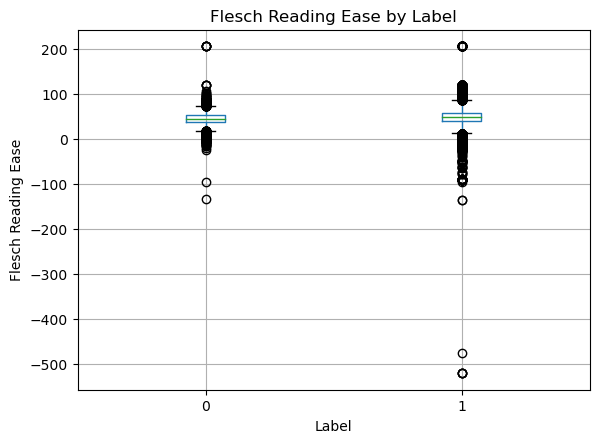

In [10]:
df.boxplot(column='flesch_reading_ease', by='label')
plt.xlabel('Label')
plt.ylabel('Flesch Reading Ease')
plt.title('Flesch Reading Ease by Label')
plt.suptitle('')
plt.show()

### Stemming/Lemmatisation
Stemming and lemmatisation are standard text normalisation techniques in natural language processing. The purpose of stemming and lemmatisation is to reduce words to their root or base form. This helps improve the accuracy of text processing because it reduces the amount of word variance. The major difference between the two techniques is that stemming reduces words to stems, which may or may not be valid, while lemmatisation reduces the words to linguistically valid lemmas. For example, the word "nothing" is reduced to "noth" with a Porter stemmer, while it remains as "nothing" using the WordNet lemmatizer. Here I am testing the results of four different techniques to see which is the most appropriate for my data:
- Porter stemmer
- Snowball stemmer
- WordNet lemmatiser
- WordNet lemmatiser with part of speech (POS) tagging.

In [11]:
#get a random sample of 10 articles
df_sample = df.sample(n=10, random_state=999).copy()
#don't need class label
df_sample.drop(columns=['label'], inplace=True)

#initialize the stemmers and lemmatizer
porter = PorterStemmer()
snowball = SnowballStemmer("english")
lemmatizer = WordNetLemmatizer()

#POS tagging code
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

# Functions for each of the stemmers/lemmatisers
def process_porter(text):
    tokens = word_tokenize(text)
    return " ".join([porter.stem(token) for token in tokens])

def process_snowball(text):
    tokens = word_tokenize(text)
    return " ".join([snowball.stem(token) for token in tokens])

def process_wordnet(text):
    tokens = word_tokenize(text)
    return " ".join([lemmatizer.lemmatize(token) for token in tokens])

def lemmatize_passage(text):
    words = word_tokenize(text)
    pos_tags = pos_tag(words)
    lemmatized_words = [lemmatizer.lemmatize(word, get_wordnet_pos(tag)) for word, tag in pos_tags]
    return ' '.join(lemmatized_words)

In [12]:
# Apply the processing functions and measure the time for each
# Porter Stemmer
start_time = time.time()
df_sample['porter'] = df_sample['content'].apply(process_porter)
print("Porter Stemmer time: {:.4f} seconds".format(time.time() - start_time))

# Snowball Stemmer
start_time = time.time()
df_sample['snowball'] = df_sample['content'].apply(process_snowball)
print("Snowball Stemmer time: {:.4f} seconds".format(time.time() - start_time))

# WordNet Lemmatizer
start_time = time.time()
df_sample['wordnet'] = df_sample['content'].apply(process_wordnet)
print("WordNet Lemmatizer time: {:.4f} seconds".format(time.time() - start_time))

# WordNet Lemmatizer with POS tagging
start_time = time.time()
df_sample['wordnetPOS'] = df_sample['content'].apply(lemmatize_passage)
print("WordNet Lemmatizer with POS tagging time: {:.4f} seconds".format(time.time() - start_time))

# Display the resulting dataframe with the new columns
df_sample.head()

Porter Stemmer time: 0.4592 seconds
Snowball Stemmer time: 0.2011 seconds
WordNet Lemmatizer time: 11.7453 seconds
WordNet Lemmatizer with POS tagging time: 0.9735 seconds


,content,word_count,sentence_count,flesch_reading_ease,porter,snowball,wordnet,wordnetPOS
23724,"Among the senseless beatings inflicted on reality during the presidential debate on Monday night was the discussion of New York City's tactics. Donald J. Trump attributed a nonexistent increase in murder to actions that never happened, namely, the ending of the practice by, variously, ""a judge, who was a very judge,"" and the ""current mayor. "" This was multilayered fiction. Murder declined. A judge did not end . Neither did the current mayor. In fact, the Police Department began to drastically curtail its use in 2012, under the administration of Mayor Michael R. Bloomberg, an independent. This is well documented but only lightly noticed. On July 9, 2012, an editorial in The New York Post warned that the reduction in its use would lead to ""more blood in the street. "" By the way, did more blood run in the street? No, less blood did. Murder is down 32 percent since 2011, the last year of the old era, having dropped to 352 homicides in 2015 from 515 in 2011. In the same period, stops were down by about 97 percent, said J. Peter Donald, a spokesman for the department. During the debate, Hillary Clinton, the Democratic nominee, alluded to a few of these numbers. Mr. Trump, her Republican opponent, started shouting. ""Under the current mayor, crime has continued to drop, including murders,"" she said. ""So there is — — "" ""No, you're wrong,"" Mr. Trump interjected. ""You're wrong. "" ""No, I'm not,"" Mrs. Clinton said. ""Murders are up, all right,"" Mr. Trump said. ""You check it. "" All right, as Mr. Trump said, let's check it. A Google search for ""Historical New York City Crime Data"" will bring you to a site with charts of serious felonies. Frisks went down. So has murder, a steady decline that has continued, with slight annual variations, through this year. In the used by Mr. Trump, those details land upside down. Also, he repeated a more common mistake about the decline of the tactics, attributing it to a federal judge hearing a lawsuit against the city, and to Mayor Bill de Blasio, a Democrat, who succeeded Mr. Bloomberg in 2014. ""It was terminated by the current mayor,"" Mr. Trump said. Actually, no. Last year, the city police conducted 22, 939 stops, or about 63 a day. So was not terminated by Mr. de Blasio, or by anyone else for that matter. It's true that the use of the tactic has declined. During the mayoralty of Mr. Bloomberg, the number of reported stops skyrocketed, but then was scaled back as the city faced pressure from the litigation, brought by the New York Civil Liberties Union and the Center for Constitutional Rights. By the end of 2013, the year Shira A. Scheindlin, the federal judge hearing the case, ruled that the city's wholesale search practices violated the Constitution, the number of stops had declined by 72 percent from its peak in 2011. ""But had a tremendous impact on the safety of New York City,"" Mr. Trump said during the debate. ""Tremendous beyond belief. So when you say it has no impact, it really did. It had a very, very big impact. "" During the era praised by Mr. Trump, about 90 percent of the people who were stopped were young black or Latino men who had committed no crime whatsoever, according to police data. Of those few who were arrested, the vast majority were charged with nothing more serious than possession of marijuana, not having guns. Hundreds of thousands of innocent people were being stopped every year so that the city could arrest tens of thousands for having weed. Applied almost exclusively to minorities, the tactics in New York became an elephantine government project that wasted time and money, degrading both to the personhood of the men and women who were stopped and to the professionalism of the people doing the stopping. It was poor social hygiene, not defensible as a matter of law or as effective law and order. As Mr. Trump said, it was ""tremendous beyond belief. "" Just s

The results with the lemmatiser are far superior to the two stemmers tested. For example, both stemmers change "president" to "presid" and "Hillary" to "hillari". Therefore I will apply the lemmatiser and POS tagging to the entire dataset.

In [13]:
#apply POS tagging and lemmatiser to entire df
start_time = time.time()
df['content_lemma'] = df['content'].progress_apply(lemmatize_passage)
print("WordNet Lemmatizer with POS tagging time: {:.4f} seconds".format(time.time() - start_time))
df.head()

  0%|          | 0/78588 [00:00<?, ?it/s]

WordNet Lemmatizer with POS tagging time: 5222.3354 seconds


,content,label,word_count,sentence_count,flesch_reading_ease,content_lemma
0,"Of course, America s favorite criminal candidate says America shouldn t believe the infamous hacker who claims he accessed her unsecured server because he s a criminal. LOL if anyone can spot a criminal, it s Crooked Hillary The infamous Romanian hacker known as Guccifer, speaking exclusively with Fox News, claimed he easily and repeatedly breached former Secretary of State Hillary Clinton s personal email server in early 2013. For me, it was easy easy for me, for everybody, Marcel Lehel Lazar, who goes by the moniker Guccifer, told Fox News from a Virginia jail where he is being held.Guccifer s potential role in the Clinton email investigation was first reported by Fox News last month. The hacker subsequently claimed he was able to access the server and provided extensive details about how he did it and what he found over the course of a half-hour jailhouse interview and a series of recorded phone calls with Fox News.Fox News could not independently confirm Lazar s claims.In response to Lazar s claims, the Clinton campaign issued a statement Wednesday night saying, There is absolutely no basis to believe the claims made by this criminal from his prison cell. In addition to the fact he offers no proof to support his claims, his descriptions of Secretary Clinton s server are inaccurate. It is unfathomable that he would have gained access to her emails and not leaked them the way he did to his other victims. The former secretary of state s server held nearly 2,200 emails containing information now deemed classified, and another 22 at the Top Secret level. Via: FOX News",1,270,11,46.61,"Of course , America s favorite criminal candidate say America shouldn t believe the infamous hacker who claim he access her unsecured server because he s a criminal . LOL if anyone can spot a criminal , it s Crooked Hillary The infamous Romanian hacker know a Guccifer , speak exclusively with Fox News , claim he easily and repeatedly breach former Secretary of State Hillary Clinton s personal email server in early 2013 . For me , it be easy easy for me , for everybody , Marcel Lehel Lazar , who go by the moniker Guccifer , tell Fox News from a Virginia jail where he be be held.Guccifer s potential role in the Clinton email investigation be first report by Fox News last month . The hacker subsequently claim he be able to access the server and provide extensive detail about how he do it and what he find over the course of a half-hour jailhouse interview and a series of recorded phone call with Fox News.Fox News could not independently confirm Lazar s claims.In response to Lazar s claim , the Clinton campaign issue a statement Wednesday night say , There be absolutely no basis to believe the claim make by this criminal from his prison cell . In addition to the fact he offer no proof to support his claim , his description of Secretary Clinton s server be inaccurate . It be unfathomable that he would have gain access to her email and not leak them the way he do to his other victim . The former secretary of state s server hold nearly 2,200 email contain information now deem classify , and another 22 at the Top Secret level . Via : FOX News"
1,"U.S. President Donald Trump expressed satisfaction on Tuesday with the federal response to Hurricane Maria s devastation of Puerto Rico, despite criticism that the government was slow to address the crisis. Trump, who has grappled with hurricanes Harvey, Irma and Maria in the past six weeks, said at a briefing that the disasters were straining the U.S. budget. I hate to tell you, Puerto Rico, but you ve thrown our budget a little out of whack because we ve spent a lot of money on Puerto Rico, he said. And that s fine. We ve saved a lot of lives. Two weeks after it was hit by the worst hurricane in 90 years, many of Puerto Rico s 3.4 million residents are still struggling without basic necessities. Shortly after Trump left Puerto Rico, Go

In [14]:
df.to_csv('phase1_lemmatised.csv', index=False)

### Remove stopwords, punctuation and lower case
Removing stopwords (a set of common words) helps reduce noise in the data. I'm removing punctuation for the same reason. Finally, I'm converting all text to lower case to reduce vocabulary size. All these decisions will reduce sparsity in the data and make modelling easier.

In [15]:
#create the stopword list and expand to include punctuation
stop_words = set(stopwords.words('english'))
stop_words.update(list(string.punctuation))

def remove_stopwords_and_punct(text):
    """
        Preprocesses a given text string by removing punctuation and stopwords and lowercasing the string.

        Parameters:
        ----------
        text : str
            The input text string to preprocess.

        Returns:
        -------
        str
            The cleaned and preprocessed text, with tokens joined back into a single string.
    """
    #lower case the text
    text = text.lower()
    #remove punctuation using regex
    text = re.sub(r'[' + re.escape(string.punctuation) + ']', '', text)
    #create tokens
    tokens = word_tokenize(text)
    #filter out stop words
    filtered_tokens = [word for word in tokens if word not in stop_words]
    #return the string
    return " ".join(filtered_tokens)

In [16]:
#apply final cleaning
start_time = time.time()
df['content_lemma_nostop'] = df['content_lemma'].apply(remove_stopwords_and_punct)
print("Removing stopwords and punctuation: {:.4f} seconds".format(time.time() - start_time))
df.head(3)

Removing stopwords and punctuation: 316.8636 seconds


,content,label,word_count,sentence_count,flesch_reading_ease,content_lemma,content_lemma_nostop
0,"Of course, America s favorite criminal candidate says America shouldn t believe the infamous hacker who claims he accessed her unsecured server because he s a criminal. LOL if anyone can spot a criminal, it s Crooked Hillary The infamous Romanian hacker known as Guccifer, speaking exclusively with Fox News, claimed he easily and repeatedly breached former Secretary of State Hillary Clinton s personal email server in early 2013. For me, it was easy easy for me, for everybody, Marcel Lehel Lazar, who goes by the moniker Guccifer, told Fox News from a Virginia jail where he is being held.Guccifer s potential role in the Clinton email investigation was first reported by Fox News last month. The hacker subsequently claimed he was able to access the server and provided extensive details about how he did it and what he found over the course of a half-hour jailhouse interview and a series of recorded phone calls with Fox News.Fox News could not independently confirm Lazar s claims.In response to Lazar s claims, the Clinton campaign issued a statement Wednesday night saying, There is absolutely no basis to believe the claims made by this criminal from his prison cell. In addition to the fact he offers no proof to support his claims, his descriptions of Secretary Clinton s server are inaccurate. It is unfathomable that he would have gained access to her emails and not leaked them the way he did to his other victims. The former secretary of state s server held nearly 2,200 emails containing information now deemed classified, and another 22 at the Top Secret level. Via: FOX News",1,270,11,46.61,"Of course , America s favorite criminal candidate say America shouldn t believe the infamous hacker who claim he access her unsecured server because he s a criminal . LOL if anyone can spot a criminal , it s Crooked Hillary The infamous Romanian hacker know a Guccifer , speak exclusively with Fox News , claim he easily and repeatedly breach former Secretary of State Hillary Clinton s personal email server in early 2013 . For me , it be easy easy for me , for everybody , Marcel Lehel Lazar , who go by the moniker Guccifer , tell Fox News from a Virginia jail where he be be held.Guccifer s potential role in the Clinton email investigation be first report by Fox News last month . The hacker subsequently claim he be able to access the server and provide extensive detail about how he do it and what he find over the course of a half-hour jailhouse interview and a series of recorded phone call with Fox News.Fox News could not independently confirm Lazar s claims.In response to Lazar s claim , the Clinton campaign issue a statement Wednesday night say , There be absolutely no basis to believe the claim make by this criminal from his prison cell . In addition to the fact he offer no proof to support his claim , his description of Secretary Clinton s server be inaccurate . It be unfathomable that he would have gain access to her email and not leak them the way he do to his other victim . The former secretary of state s server hold nearly 2,200 email contain information now deem classify , and another 22 at the Top Secret level . Via : FOX News",course america favorite criminal candidate say america believe infamous hacker claim access unsecured server criminal lol anyone spot criminal crooked hillary infamous romanian hacker know guccifer speak exclusively fox news claim easily repeatedly breach former secretary state hillary clinton personal email server early 2013 easy easy everybody marcel lehel lazar go moniker guccifer tell fox news virginia jail heldguccifer potential role clinton email investigation first report fox news last month hacker subsequently claim able access server provide extensive detail find course halfhour jailhouse interview series recorded phone call fox newsfox news could independently confirm lazar claimsin response lazar claim clinto

In [17]:
df.to_csv('phase1_final_clean.csv', index=False)

### Data Exploration
Let's have a quick look at our cleaned data to understand it a little better.

In [18]:
def get_top_n_words_by_class(df, text_column, label_column, n=10):
    """
    Returns the top n words for each class in the dataframe.

    Parameters:
    -----------
    df : pd.DataFrame
        The DataFrame containing the text data.
    text_column : string
        The name of the column containing the text.
    label_column : string
        The name of the column containing the class labels.
    n : int (optional)
        The number of top n-grams to return. (default is 10)

    Returns:
    --------
    dict
        A dictionary where keys are class labels and values are lists of tuples, each tuple containing a word and its frequency.
    """
    top_words_by_class = {}
    for label in df[label_column].unique():
        #get the texts for just one class
        texts = df[df[label_column] == label][text_column]
        #create a CountVectorizer
        vectorizer = CountVectorizer()
        X = vectorizer.fit_transform(texts)
        #sum up word counts over all documents in this class
        word_counts = np.asarray(X.sum(axis=0)).flatten()
        words = vectorizer.get_feature_names_out()
        #get indices for the top n words (in descending order)
        top_n_idx = word_counts.argsort()[::-1][:n]
        top_words = [(words[i], word_counts[i]) for i in top_n_idx]
        top_words_by_class[label] = top_words
    return top_words_by_class

#get top 10 words for each class
top_words = get_top_n_words_by_class(df, 'content_lemma_nostop', 'label', n=10)
for label, words in top_words.items():
    print(f"Top words for class {label}:")
    print(words)
    print()

Top words for class 1:
[('trump', np.int64(99956)), ('say', np.int64(78480)), ('people', np.int64(48802)), ('one', np.int64(45146)), ('would', np.int64(43607)), ('clinton', np.int64(43106)), ('go', np.int64(40132)), ('make', np.int64(39808)), ('president', np.int64(37072)), ('us', np.int64(35057))]

Top words for class 0:
[('say', np.int64(199817)), ('trump', np.int64(96299)), ('mr', np.int64(65267)), ('would', np.int64(57653)), ('president', np.int64(46942)), ('state', np.int64(43205)), ('year', np.int64(41470)), ('one', np.int64(40049)), ('us', np.int64(38768)), ('people', np.int64(38553))]



In [39]:
def get_top_n_ngrams_by_class(df, text_column, label_column, ngram_range=(2, 2), n=10):
    """
    Returns the top n n-grams for each class in the dataframe.

    Parameters:
    -----------
    df : pd.DataFrame
        The DataFrame containing the text data.
    text_column : str
        The name of the column containing the text.
    label_column : str
        The name of the column containing the class labels.
    ngram_range : tuple (min_n, max_n)
        The lower and upper boundary of the range of n-values for different n-grams.
    n : int (optional)
        The number of top n-grams to return. (default is 10)

    Returns:
    --------
    dict
        A dictionary where keys are class labels and values are lists of tuples, each tuple containing an n-gram and its frequency.
    """
    top_ngrams_by_class = {}

    for label in df[label_column].unique():
        #get the texts for only 1 class
        subset = df[df[label_column] == label]
        #initialize the vectorizer
        vectorizer = CountVectorizer(ngram_range=ngram_range)
        X = vectorizer.fit_transform(subset[text_column])
        #sum word counts for each n-gram in the subset
        ngram_counts = np.asarray(X.sum(axis=0)).flatten()
        ngrams = vectorizer.get_feature_names_out()
        #get indices of the top n n-grams, sorted by frequency
        top_n_idx = ngram_counts.argsort()[::-1][:n]
        top_ngrams = [(ngrams[i], ngram_counts[i]) for i in top_n_idx]
        top_ngrams_by_class[label] = top_ngrams

    return top_ngrams_by_class

#get top 10 bigrams for each class
top_ngrams = get_top_n_ngrams_by_class(df, 'content_lemma_nostop', 'label', ngram_range=(2,2), n=10)
for label, ngrams in top_ngrams.items():
    print(f"Top bi-grams for class {label}:")
    print(ngrams)

Top bi-grams for class 1:
[('donald trump', np.int64(22026)), ('hillary clinton', np.int64(15748)), ('united states', np.int64(11773)), ('white house', np.int64(9124)), ('new york', np.int64(6728)), ('image via', np.int64(6395)), ('president obama', np.int64(4890)), ('president trump', np.int64(4009)), ('fox news', np.int64(3839)), ('barack obama', np.int64(3405))]
Top bi-grams for class 0:
[('united states', np.int64(20250)), ('mr trump', np.int64(17293)), ('donald trump', np.int64(16035)), ('white house', np.int64(12787)), ('new york', np.int64(10590)), ('president donald', np.int64(6791)), ('last year', np.int64(6239)), ('hillary clinton', np.int64(5745)), ('north korea', np.int64(5723)), ('trump say', np.int64(5651))]


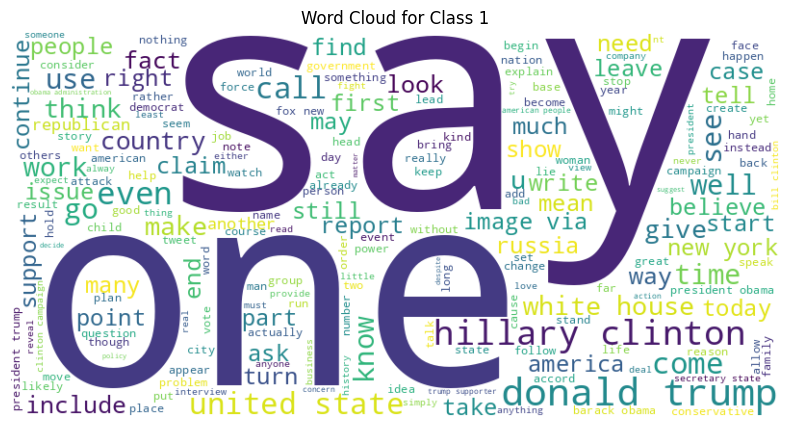

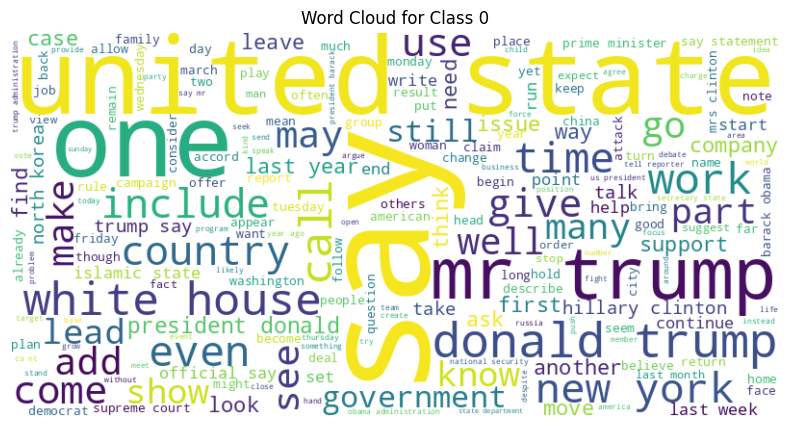

In [20]:
def plot_wordclouds_by_class(df, text_column, label_column, width=800, height=400, bg_color='white'):
    """
    Generates and displays a word cloud for each class in the DataFrame.

    Parameters:
    -----------
    df : pd.DataFrame
        The DataFrame containing your data.
    text_column : string
        The name of the column that contains the text to analyze.
    label_column : string
        The name of the column containing the class labels.
    width : int (optional)
        The width of the generated word cloud image (default is 800).
    height : int (optional)
        The height of the generated word cloud image (default is 400).
    bg_color : string (optional)
        The background color for the word cloud (default is 'white').
        
    Returns:
    --------
    Nothing - displays a wordcloud for each class
    """
    #get the unique class labels
    classes = df[label_column].unique()

    for cls in classes:
        #combine text for the current class
        class_text = " ".join(df[df[label_column] == cls][text_column].dropna())

        #generate wordcloud
        wordcloud = WordCloud(width=width, height=height, background_color=bg_color).generate(class_text)

        #plot wordcloud
        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis("off")
        plt.title(f"Word Cloud for Class {cls}")
        plt.show()

plot_wordclouds_by_class(df, text_column='content_lemma_nostop', label_column='label')

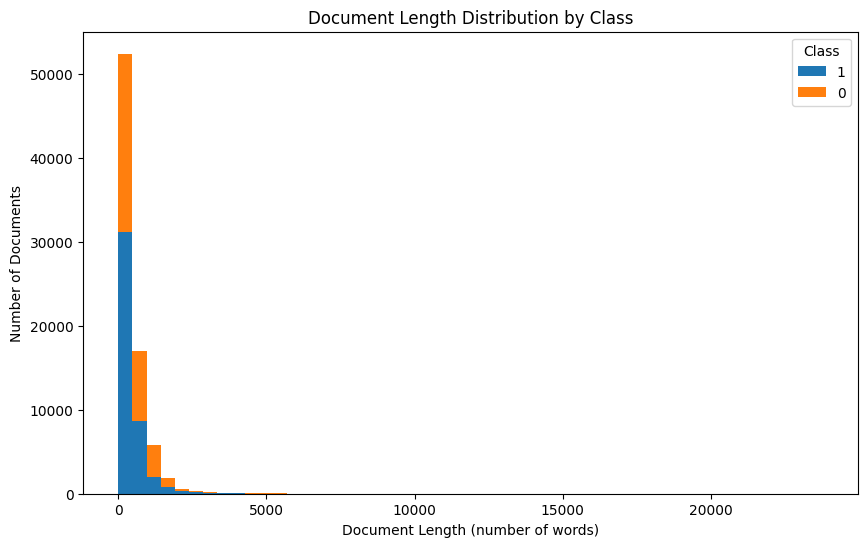

In [21]:
#see document length distribution by class
df['doc_length'] = df['content'].apply(lambda x: len(x.split()))
classes = df['label'].unique()
lengths_by_class = [df[df['label'] == cls]['doc_length'] for cls in classes]

#plot a stacked histogram of document lengths by class
plt.figure(figsize=(10, 6))
plt.hist(lengths_by_class, bins=50, stacked=True, label=classes)
plt.xlabel('Document Length (number of words)')
plt.ylabel('Number of Documents')
plt.title('Document Length Distribution by Class')
plt.legend(title='Class')
plt.show()

## Phase 2: Misinformation Typology Classification
For the second stage, a new dataset was created (see data scraping notebook) to classify misinformation into one
of four categories from the Molina taxonomy. 400 articles per label were collected, resulting in a balanced dataset of 1,600 samples.

We will apply the exact same cleaning steps as before to this new dataset.

In [22]:
df2 = pd.read_csv('master.csv')
#shuffle the dataset
df2 = df2.sample(frac=1, random_state=999).reset_index(drop=True)
#combine the title and text columns into a single column
df2['content'] = df2['title'].fillna('') + " " + df2['text'].fillna('')
#drop unnecessary columns
df2 = df2[['content', 'class']]
#basic checks
print("DataFrame Info:")
df2.info()
print("\nClass overview:")
print(df2['class'].value_counts())
#encode the classes
le = LabelEncoder()
df2['label'] = le.fit_transform(df2['class'])
#see the mapping
mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print("Label mapping:", mapping)
#drop unnecessary columns
df2 = df2[['content', 'label']]
#store
df2.to_csv('phase2_first_clean.csv', index=False)

DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600 entries, 0 to 1599
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   content  1600 non-null   object
 1   class    1600 non-null   object
dtypes: object(2)
memory usage: 25.1+ KB

Class overview:
class
Satire        400
Polarised     400
fabricated    400
Commentary    400
Name: count, dtype: int64
Label mapping: {'Commentary': np.int64(0), 'Polarised': np.int64(1), 'Satire': np.int64(2), 'fabricated': np.int64(3)}


In [23]:
start_time = time.time()
df2['content'] = df2['content'].progress_apply(basic_clean)
print("Basic clean: {:.4f} seconds".format(time.time() - start_time))
df2.head(3)

  0%|          | 0/1600 [00:00<?, ?it/s]

Basic clean: 3.5658 seconds


,content,label
0,"Perdue Announces Initiative To Even The Playing Field By Giving Chickens Guns SALISBURY, MD--Emphasizing that it was an integral part of the company's mission to raise humanely sourced meat, poultry processing giant Perdue Farms announced a new initiative Tuesday to even the playing field by giving guns to chickens. ""At Perdue, we always strive to ensure animals are treated with dignity and respect, and today we expand upon that commitment by handing each bird a loaded pistol and allowing them a fair chance to escape,"" said Perdue spokesperson Jamie Walton, describing a new policy under which each chicken would be issued a weapon with a single round in the chamber and given an opportunity to kill their captor with a well-placed bullet before they could be taken to slaughter. ""They should get one clean shot. That's just good sportsmanship. So from now on, every chicken in our Perdue facilities will have free and easy access to firearms. We may lose some staff to gunshot wounds, but everyone involved--human or fowl--will have an opportunity to defend themselves. It's only right."" At press time, sources confirmed a shift in the balance of power at several Perdue processing plants had resulted in thousands of employees being slaughter with assembly-line efficiency.",2
1,"Met Police just BLOCKED a pro-Palestine protest from marching outside the BBC Today the Palestine Coalition have been informed by the Met Police that they intend to go back on a previous agreement and impose conditions to prevent us marching from BBC HQ at Portland Place on Saturday 18 January. We have already announced our intention to assemble outside the BBC to protest against the pro-Israel bias of its coverage - something recently highlighted in a detailed report by journalist Owen Jones to which the Corporation has so far not responded. We utterly condemn this attempt to use repressive powers to prevent our planned protest at the BBC. The route for the march was confirmed with the police nearly two months ago and, as agreed with them, was publicly announced on 30 November. This route, beginning at the BBC, has only been used twice in the last 15 months of demonstrations and not since February 2024. With just over a week to go, the Metropolitan Police has now reneged on our agreement and stated its intention to prevent our protest from going ahead as planned. The BBC is a major institution - it is a publicly-funded state broadcaster and is rightly accountable to the public. It is unacceptable for the police to misuse public order powers to shield the BBC from democratic scrutiny. The excuse offered by the police is that our march could cause disruption to a nearby synagogue. It follows representations from pro-Israel groups and activists who have been publicly calling for action to be taken to curtail our right to protest against Israel's ongoing genocide. This includes the Chief Rabbi, Ephraim Mirvis who has openly celebrated the horrific and criminal actions of the Israeli military in Gaza, describing them as the ""most outstanding possible thing that a decent responsible country can do"". In fact, the closest synagogue to the BBC is not even on the route of the march. Moreover, as the Met Police have acknowledged, there has not been a single incident of any threat to a synagogue attached to any of the marches. Any suggestion that our marches are somehow hostile to Jewish people ignores the fact that every march has been joined by thousands of Jewish people - many in an organised Jewish bloc - and addressed by Jewish speakers on the demonstration platforms. Representatives of the Jewish bloc have written to the police seeking a meeting to express their concerns that the police are choosing to listen solely to pro-Israel Jewish voices, but they have not had any response. We firmly reject any attempt to suppress our right to campaign for an end to Israel's genocidal violence and decades long violations of the rights of the Palestinian pe

In [24]:
#readability metrics
df2['word_count'] = df2['content'].apply(lambda x: len(x.split()))
df2['sentence_count'] = df2['content'].apply(lambda x: (textstat.sentence_count(x)))
df2['flesch_reading_ease'] = df2['content'].apply(lambda x: textstat.flesch_reading_ease(x))

In [25]:
#apply POS tagging and lemmatiser to entire df
start_time = time.time()
df2['content_lemma'] = df2['content'].progress_apply(lemmatize_passage)
print("WordNet Lemmatizer with POS tagging time: {:.4f} seconds".format(time.time() - start_time))
df2.head()

  0%|          | 0/1600 [00:00<?, ?it/s]

WordNet Lemmatizer with POS tagging time: 35.2718 seconds


,content,label,word_count,sentence_count,flesch_reading_ease,content_lemma
0,"Perdue Announces Initiative To Even The Playing Field By Giving Chickens Guns SALISBURY, MD--Emphasizing that it was an integral part of the company's mission to raise humanely sourced meat, poultry processing giant Perdue Farms announced a new initiative Tuesday to even the playing field by giving guns to chickens. ""At Perdue, we always strive to ensure animals are treated with dignity and respect, and today we expand upon that commitment by handing each bird a loaded pistol and allowing them a fair chance to escape,"" said Perdue spokesperson Jamie Walton, describing a new policy under which each chicken would be issued a weapon with a single round in the chamber and given an opportunity to kill their captor with a well-placed bullet before they could be taken to slaughter. ""They should get one clean shot. That's just good sportsmanship. So from now on, every chicken in our Perdue facilities will have free and easy access to firearms. We may lose some staff to gunshot wounds, but everyone involved--human or fowl--will have an opportunity to defend themselves. It's only right."" At press time, sources confirmed a shift in the balance of power at several Perdue processing plants had resulted in thousands of employees being slaughter with assembly-line efficiency.",2,207,8,45.19,"Perdue Announces Initiative To Even The Playing Field By Giving Chickens Guns SALISBURY , MD -- Emphasizing that it be an integral part of the company 's mission to raise humanely sourced meat , poultry processing giant Perdue Farms announce a new initiative Tuesday to even the playing field by give gun to chicken . `` At Perdue , we always strive to ensure animal be treat with dignity and respect , and today we expand upon that commitment by hand each bird a loaded pistol and allow them a fair chance to escape , '' say Perdue spokesperson Jamie Walton , describe a new policy under which each chicken would be issue a weapon with a single round in the chamber and give an opportunity to kill their captor with a well-placed bullet before they could be take to slaughter . `` They should get one clean shot . That 's just good sportsmanship . So from now on , every chicken in our Perdue facility will have free and easy access to firearm . We may lose some staff to gunshot wound , but everyone involve -- human or fowl -- will have an opportunity to defend themselves . It 's only right . '' At press time , source confirm a shift in the balance of power at several Perdue processing plant have result in thousand of employee be slaughter with assembly-line efficiency ."
1,"Met Police just BLOCKED a pro-Palestine protest from marching outside the BBC Today the Palestine Coalition have been informed by the Met Police that they intend to go back on a previous agreement and impose conditions to prevent us marching from BBC HQ at Portland Place on Saturday 18 January. We have already announced our intention to assemble outside the BBC to protest against the pro-Israel bias of its coverage - something recently highlighted in a detailed report by journalist Owen Jones to which the Corporation has so far not responded. We utterly condemn this attempt to use repressive powers to prevent our planned protest at the BBC. The route for the march was confirmed with the police nearly two months ago and, as agreed with them, was publicly announced on 30 November. This route, beginning at the BBC, has only been used twice in the last 15 months of demonstrations and not since February 2024. With just over a week to go, the Metropolitan Police has now reneged on our agreement and stated its intention to prevent our protest from going ahead as planned. The BBC is a major institution - it is a publicly-funded state broadcaster and is rightly accountable to the public. It is unacceptable for the police to misuse public order powers to shield the BBC from democratic scrutiny. The excuse offered by the polic

In [26]:
#apply final cleaning
start_time = time.time()
df2['content_lemma_nostop'] = df2['content_lemma'].apply(remove_stopwords_and_punct)
print("Removing stopwords and punctuation: {:.4f} seconds".format(time.time() - start_time))
df2.head(3)

Removing stopwords and punctuation: 2.4640 seconds


,content,label,word_count,sentence_count,flesch_reading_ease,content_lemma,content_lemma_nostop
0,"Perdue Announces Initiative To Even The Playing Field By Giving Chickens Guns SALISBURY, MD--Emphasizing that it was an integral part of the company's mission to raise humanely sourced meat, poultry processing giant Perdue Farms announced a new initiative Tuesday to even the playing field by giving guns to chickens. ""At Perdue, we always strive to ensure animals are treated with dignity and respect, and today we expand upon that commitment by handing each bird a loaded pistol and allowing them a fair chance to escape,"" said Perdue spokesperson Jamie Walton, describing a new policy under which each chicken would be issued a weapon with a single round in the chamber and given an opportunity to kill their captor with a well-placed bullet before they could be taken to slaughter. ""They should get one clean shot. That's just good sportsmanship. So from now on, every chicken in our Perdue facilities will have free and easy access to firearms. We may lose some staff to gunshot wounds, but everyone involved--human or fowl--will have an opportunity to defend themselves. It's only right."" At press time, sources confirmed a shift in the balance of power at several Perdue processing plants had resulted in thousands of employees being slaughter with assembly-line efficiency.",2,207,8,45.19,"Perdue Announces Initiative To Even The Playing Field By Giving Chickens Guns SALISBURY , MD -- Emphasizing that it be an integral part of the company 's mission to raise humanely sourced meat , poultry processing giant Perdue Farms announce a new initiative Tuesday to even the playing field by give gun to chicken . `` At Perdue , we always strive to ensure animal be treat with dignity and respect , and today we expand upon that commitment by hand each bird a loaded pistol and allow them a fair chance to escape , '' say Perdue spokesperson Jamie Walton , describe a new policy under which each chicken would be issue a weapon with a single round in the chamber and give an opportunity to kill their captor with a well-placed bullet before they could be take to slaughter . `` They should get one clean shot . That 's just good sportsmanship . So from now on , every chicken in our Perdue facility will have free and easy access to firearm . We may lose some staff to gunshot wound , but everyone involve -- human or fowl -- will have an opportunity to defend themselves . It 's only right . '' At press time , source confirm a shift in the balance of power at several Perdue processing plant have result in thousand of employee be slaughter with assembly-line efficiency .",perdue announces initiative even playing field giving chickens guns salisbury md emphasizing integral part company mission raise humanely sourced meat poultry processing giant perdue farms announce new initiative tuesday even playing field give gun chicken perdue always strive ensure animal treat dignity respect today expand upon commitment hand bird loaded pistol allow fair chance escape say perdue spokesperson jamie walton describe new policy chicken would issue weapon single round chamber give opportunity kill captor wellplaced bullet could take slaughter get one clean shot good sportsmanship every chicken perdue facility free easy access firearm may lose staff gunshot wound everyone involve human fowl opportunity defend right press time source confirm shift balance power several perdue processing plant result thousand employee slaughter assemblyline efficiency
1,"Met Police just BLOCKED a pro-Palestine protest from marching outside the BBC Today the Palestine Coalition have been informed by the Met Police that they intend to go back on a previous agreement and impose conditions to prevent us marching from BBC HQ at Portland Place on Saturday 18 January. We have already announced our intention to assemble outside the BBC to protest against the pro-Israel bias of its coverage - something recently

In [27]:
df2.to_csv('phase2_final_clean.csv', index=False)

### Data Exploration

In [28]:
#get top 10 words for each class
top_words = get_top_n_words_by_class(df2, 'content_lemma_nostop', 'label', n=10)
for label, words in top_words.items():
    print(f"Top words for class {label}:")
    print(words)
    print()

Top words for class 2:
[('say', np.int64(487)), ('one', np.int64(400)), ('nt', np.int64(379)), ('people', np.int64(311)), ('time', np.int64(305)), ('like', np.int64(300)), ('get', np.int64(285)), ('trump', np.int64(261)), ('make', np.int64(230)), ('would', np.int64(224))]

Top words for class 1:
[('trump', np.int64(1462)), ('say', np.int64(1105)), ('people', np.int64(920)), ('one', np.int64(694)), ('nt', np.int64(687)), ('year', np.int64(641)), ('make', np.int64(631)), ('government', np.int64(619)), ('would', np.int64(611)), ('also', np.int64(579))]

Top words for class 3:
[('says', np.int64(92)), ('claim', np.int64(52)), ('obama', np.int64(45)), ('health', np.int64(37)), ('say', np.int64(37)), ('narrative', np.int64(33)), ('president', np.int64(32)), ('state', np.int64(31)), ('one', np.int64(30)), ('government', np.int64(30))]

Top words for class 0:
[('trump', np.int64(1922)), ('people', np.int64(1100)), ('nt', np.int64(1080)), ('one', np.int64(1073)), ('would', np.int64(1051)), ('sa

In [29]:
#get top 10 bigrams for each class
top_ngrams = get_top_n_ngrams_by_class(df2, 'content_lemma_nostop', 'label', ngram_range=(2,2), n=10)
for label, ngrams in top_ngrams.items():
    print(f"Top bi-grams for class {label}:")
    print(ngrams)

Top bi-grams for class 2:
[('press time', np.int64(66)), ('ca nt', np.int64(65)), ('donald trump', np.int64(48)), ('say one', np.int64(42)), ('joe biden', np.int64(42)), ('meghan markle', np.int64(41)), ('washington dc', np.int64(38)), ('united states', np.int64(31)), ('elon musk', np.int64(27)), ('social medium', np.int64(25))]
Top bi-grams for class 1:
[('donald trump', np.int64(204)), ('per cent', np.int64(153)), ('united states', np.int64(116)), ('social medium', np.int64(77)), ('disabled people', np.int64(77)), ('executive order', np.int64(76)), ('last year', np.int64(70)), ('joe biden', np.int64(68)), ('prime minister', np.int64(62)), ('white house', np.int64(62))]
Top bi-grams for class 3:
[('barack obama', np.int64(17)), ('health care', np.int64(16)), ('according fabricate', np.int64(11)), ('hillary clinton', np.int64(11)), ('according entirely', np.int64(9)), ('fabricate narrative', np.int64(9)), ('president barack', np.int64(9)), ('scott walker', np.int64(8)), ('united states

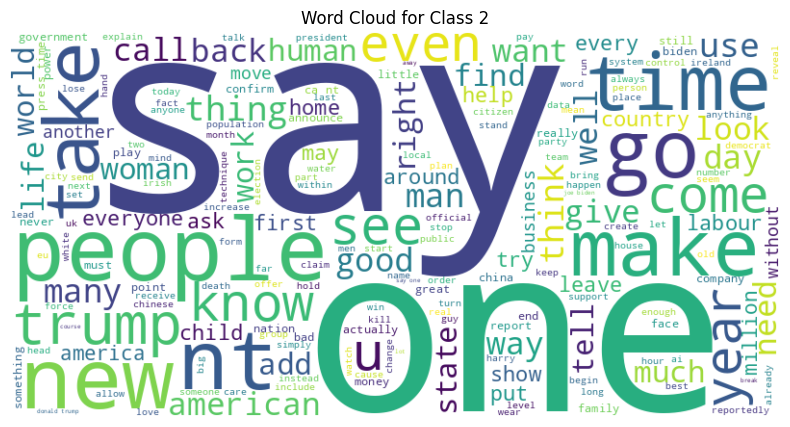

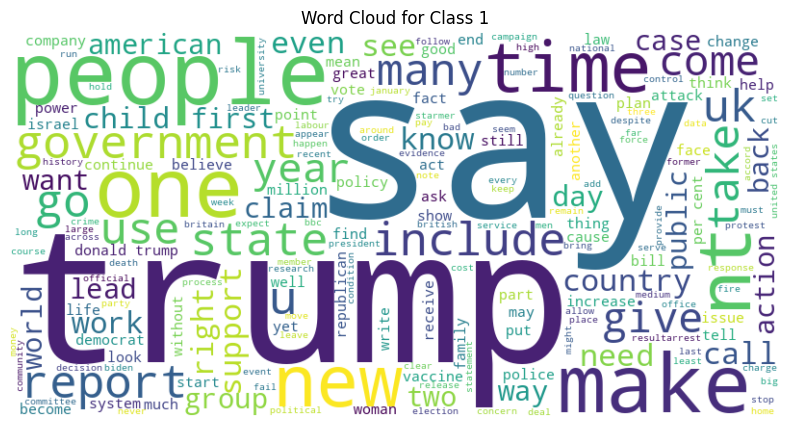

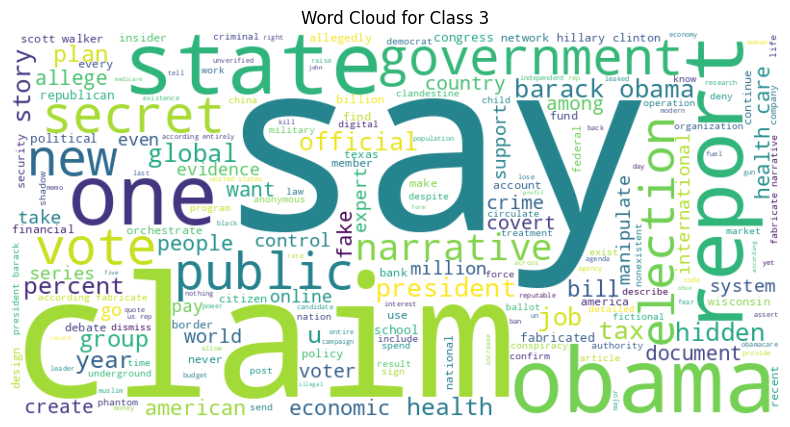

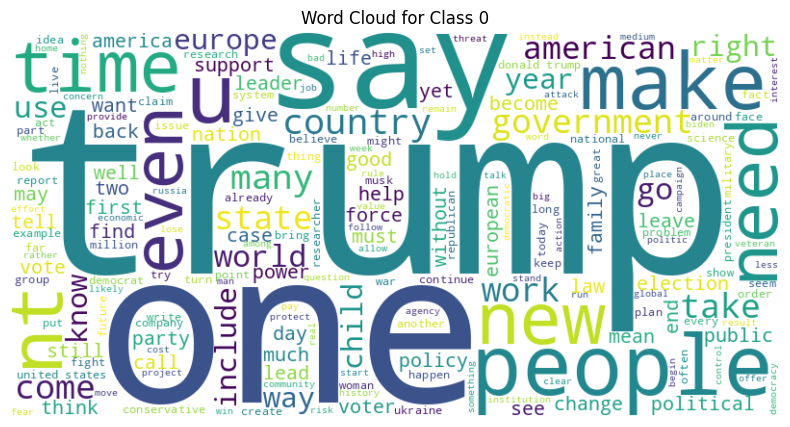

In [30]:
#print wordcloud for each class
plot_wordclouds_by_class(df2, text_column='content_lemma_nostop', label_column='label')

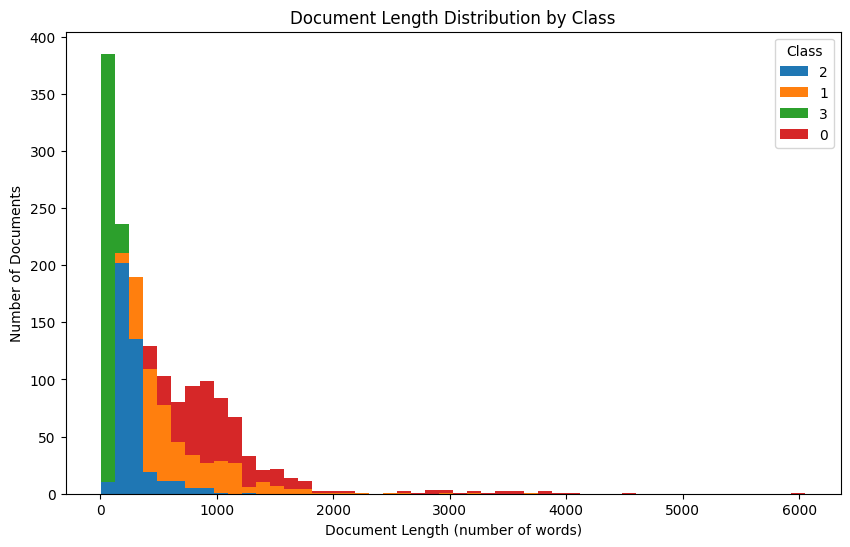

In [31]:
#see document length distribution by class
df2['doc_length'] = df2['content'].apply(lambda x: len(x.split()))
classes = df2['label'].unique()
lengths_by_class = [df2[df2['label'] == cls]['doc_length'] for cls in classes]

#plot a stacked histogram of document lengths by class
plt.figure(figsize=(10, 6))
plt.hist(lengths_by_class, bins=50, stacked=True, label=classes)
plt.xlabel('Document Length (number of words)')
plt.ylabel('Number of Documents')
plt.title('Document Length Distribution by Class')
plt.legend(title='Class')
plt.show()

## Extra dataset to validate
Extra data from ISOT dataset, downloaded from https://onlineacademiccommunity.uvic.ca/isot/2022/11/27/fake-news-detection-datasets/. This will be used to sense check the phase 1 model later. The same preprocessing is applied as to the Phase 1 and Phase 2 data.

This step is necessary becuase the prototype was developed on the ISOT data and it performed incredibly well, but then I realised that all "true" articles started with the phrase "REUTERS" which meant it generalised very poorly on other data.

In [32]:
fake_df = pd.read_csv('ISOT-Fake.csv')
fake_df = fake_df.sample(n=250, random_state=123).copy()
fake_df['label'] = 1
true_df = pd.read_csv('ISOT-True.csv')
true_df = fake_df.sample(n=250, random_state=123).copy()
true_df['label'] = 0
#combine the dataframes
data = pd.concat([true_df, fake_df], ignore_index=True)
#shuffle the dataset
data = data.sample(frac=1, random_state=999).reset_index(drop=True)
#combine the title and text columns into a single column
data['content'] = data['title'] + " " + data['text']
#drop unnecessary columns
data = data[['content', 'label']]
#check we have 250 of each, and print the head
print(data['label'].value_counts())
print(data.head())
#store
data.to_csv('ExtraDataset.csv', index=False)

label
0    250
1    250
Name: count, dtype: int64
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      

In [33]:
start_time = time.time()
#replace the censored words
data['content'] = data['content'].progress_apply(lambda x: replace_censored_words(x, substitutions))
#take care of the other random asterixes by replacing with a space e.g. "language***killer" and "2016*you"
data['content'] = data['content'].str.replace(r'\*', ' ', regex=True)
#remove twitter noise (any time twitter is repeated 3 or more times in a row)
data['content'] = data['content'].str.replace(r'(?i)(?:twitter){3,}', ' ', regex=True)
#print time taken
print("Replace censored words: {:.4f} seconds".format(time.time() - start_time))
#quick check
data.head(3)

  0%|          | 0/500 [00:00<?, ?it/s]

Replace censored words: 0.2683 seconds


content  \
0  The Jerusalem Decision: From Creative Chaos to Effective Turmoil  Dr Can Erimtan 21st Century WireDid Donald J. Trump have any idea about the impact his words would have across the world?!? Did he have any idea that the whole wide world, including the United Nations, would turn against him?On Wednesday, 6 December 2017, in the White House s Diplomatic Reception Room the President of the United States proceeded to make history, or, proceeded to leave his personal mark on the flow of world events as his words set a whole chain of global events in motion: I have determined that it is time to officially recognize Jerusalem as the capital of Israel. While previous presidents have made this a major campaign promise, they failed to deliver. Today, I am delivering. In his preamble to this potentially explosive and arguably rather disconcerting statement, Trump explained that  [i]n 1995, [under Bill Clinton s watch, that is] Congress adopted the Jerusalem Embassy Act, urging the federal government to relocate the American embassy to Jerusalem and to recognize that that city   and so importantly   is Israel s capital. This act passed Congress by an overwhelming bipartisan majority and was reaffirmed by a unanimous vote of the Senate only six months ago.  In this way, the 45th U.S. President showed himself to have been cut from a completely different cloth indeed, as he uttered words that neither Bill Clinton, nor George W. Bush or, more importantly perhaps, Barack Obama had dared speak.Yes, Trump openly came out and made plain the deep love that dare not speak its name   in spite of the vehemently pro-Israel stance taken by the U.S. ever since the time of President Eisenhower (1953-61) and particularly, ever since the Six Day War (5-10 June 1967), in spite of the ceaseless activities of AIPAC and J Street, no previous incumbent had dared bestow a bona fide U.S. Embassy to Jerusalem as a physical token of the deep and ardent bonds between the New World and the Promised Land. Only, Donald J. Trump had the gall to  deliver,  doing what Clinton had promised yet none of his successors had been able to realise . . . until now, that is.In true Aristotelian fashion Trump took the potentiality that was Jerusalem (known as Al Quds or the Sacred City in the Muslim world) and turned it into an actuality by means of pledging full ambassadorial honours for the ancient city. Following these presidential words, outspoken Israeli voices did not take long to heap praise on the White House. Mark Regev, the erstwhile spokesman for the Ministry of Foreign Affairs in Jerusalem (2004-7) and frequent Israeli apologist appearing on various mainstream media, and currently even active as Israeli Ambassador in London (since 2015) blurted out that he  think[s] this was a just move and a good move for peace. His boss, Bibi or Benjamin Netanyahu (fourth premiership, 2015 present) was equally forthcoming, talking to the press on the same day the U.S. President made his performance in the Diplomatic Reception Room:  Thank you President Trump for today s historic decision to recognize Jerusalem as Israel s capital. The Jewish people and the Jewish state will be forever grateful.  The PM in the next instance also echoed his ambassador s words, declaring that  [t]here is no peace that doesn t include Jerusalem as the capital of Israel. The idea that Jerusalem should be at the heart of the Jewish people s  land and nation namely has its roots in the Bible, in 2 Chronicles 6:5-6, to be precise:  Since the day I brought my people out of Egypt, I have not chosen a city in any tribe of Israel to have a temple built so that my Name might be there, nor have I chosen anyone to be ruler over my people Israel. But now I have chosen Jerusalem for my Name to be there, and I have chosen David to rule my people Israel,  as worded in the New International Version. And Bibi knows that too.Bibi even took his words of praise abroad. First to Paris, where he met with President

In [34]:
start_time = time.time()
data['content'] = data['content'].progress_apply(basic_clean)
print("Basic clean: {:.4f} seconds".format(time.time() - start_time))
data.head(3)

  0%|          | 0/500 [00:00<?, ?it/s]

Basic clean: 0.9828 seconds


content  \
0  The Jerusalem Decision: From Creative Chaos to Effective Turmoil Dr Can Erimtan 21st Century WireDid Donald J. Trump have any idea about the impact his words would have across the world?!? Did he have any idea that the whole wide world, including the United Nations, would turn against him?On Wednesday, 6 December 2017, in the White House s Diplomatic Reception Room the President of the United States proceeded to make history, or, proceeded to leave his personal mark on the flow of world events as his words set a whole chain of global events in motion: I have determined that it is time to officially recognize Jerusalem as the capital of Israel. While previous presidents have made this a major campaign promise, they failed to deliver. Today, I am delivering. In his preamble to this potentially explosive and arguably rather disconcerting statement, Trump explained that n 1995,  Congress adopted the Jerusalem Embassy Act, urging the federal government to relocate the American embassy to Jerusalem and to recognize that that city and so importantly is Israel s capital. This act passed Congress by an overwhelming bipartisan majority and was reaffirmed by a unanimous vote of the Senate only six months ago. In this way, the 45th U.S. President showed himself to have been cut from a completely different cloth indeed, as he uttered words that neither Bill Clinton, nor George W. Bush or, more importantly perhaps, Barack Obama had dared speak.Yes, Trump openly came out and made plain the deep love that dare not speak its name in spite of the vehemently pro-Israel stance taken by the U.S. ever since the time of President Eisenhower  and particularly, ever since the Six Day War , in spite of the ceaseless activities of AIPAC and J Street, no previous incumbent had dared bestow a bona fide U.S. Embassy to Jerusalem as a physical token of the deep and ardent bonds between the New World and the Promised Land. Only, Donald J. Trump had the gall to deliver, doing what Clinton had promised yet none of his successors had been able to realise . . . until now, that is.In true Aristotelian fashion Trump took the potentiality that was Jerusalem  and turned it into an actuality by means of pledging full ambassadorial honours for the ancient city. Following these presidential words, outspoken Israeli voices did not take long to heap praise on the White House. Mark Regev, the erstwhile spokesman for the Ministry of Foreign Affairs in Jerusalem  and frequent Israeli apologist appearing on various mainstream media, and currently even active as Israeli Ambassador in London  blurted out that he think this was a just move and a good move for peace. His boss, Bibi or Benjamin Netanyahu  was equally forthcoming, talking to the press on the same day the U.S. President made his performance in the Diplomatic Reception Room: Thank you President Trump for today s historic decision to recognize Jerusalem as Israel s capital. The Jewish people and the Jewish state will be forever grateful. The PM in the next instance also echoed his ambassador s words, declaring that here is no peace that doesn t include Jerusalem as the capital of Israel. The idea that Jerusalem should be at the heart of the Jewish people s land and nation namely has its roots in the Bible, in 2 Chronicles 6:5-6, to be precise: Since the day I brought my people out of Egypt, I have not chosen a city in any tribe of Israel to have a temple built so that my Name might be there, nor have I chosen anyone to be ruler over my people Israel. But now I have chosen Jerusalem for my Name to be there, and I have chosen David to rule my people Israel, as worded in the New International Version. And Bibi knows that too.Bibi even took his words of praise abroad. First to Paris, where he met with President Emmanuel Macron, who had urged his U.S. counterpart to preserve the city s status quo prior to Trump s Diplomatic Reception Room performance . Bibi disagreed volubly with the Frenchman, characterisin

In [35]:
data['word_count'] = data['content'].apply(lambda x: len(x.split()))
data['sentence_count'] = data['content'].apply(lambda x: (textstat.sentence_count(x)))
data['flesch_reading_ease'] = data['content'].apply(lambda x: textstat.flesch_reading_ease(x))

In [36]:
#apply POS tagging and lemmatiser to entire df
start_time = time.time()
data['content_lemma'] = data['content'].progress_apply(lemmatize_passage)
print("WordNet Lemmatizer with POS tagging time: {:.4f} seconds".format(time.time() - start_time))
data.head(3)

  0%|          | 0/500 [00:00<?, ?it/s]

WordNet Lemmatizer with POS tagging time: 9.3338 seconds


content  \
0  The Jerusalem Decision: From Creative Chaos to Effective Turmoil Dr Can Erimtan 21st Century WireDid Donald J. Trump have any idea about the impact his words would have across the world?!? Did he have any idea that the whole wide world, including the United Nations, would turn against him?On Wednesday, 6 December 2017, in the White House s Diplomatic Reception Room the President of the United States proceeded to make history, or, proceeded to leave his personal mark on the flow of world events as his words set a whole chain of global events in motion: I have determined that it is time to officially recognize Jerusalem as the capital of Israel. While previous presidents have made this a major campaign promise, they failed to deliver. Today, I am delivering. In his preamble to this potentially explosive and arguably rather disconcerting statement, Trump explained that n 1995,  Congress adopted the Jerusalem Embassy Act, urging the federal government to relocate the American embassy to Jerusalem and to recognize that that city and so importantly is Israel s capital. This act passed Congress by an overwhelming bipartisan majority and was reaffirmed by a unanimous vote of the Senate only six months ago. In this way, the 45th U.S. President showed himself to have been cut from a completely different cloth indeed, as he uttered words that neither Bill Clinton, nor George W. Bush or, more importantly perhaps, Barack Obama had dared speak.Yes, Trump openly came out and made plain the deep love that dare not speak its name in spite of the vehemently pro-Israel stance taken by the U.S. ever since the time of President Eisenhower  and particularly, ever since the Six Day War , in spite of the ceaseless activities of AIPAC and J Street, no previous incumbent had dared bestow a bona fide U.S. Embassy to Jerusalem as a physical token of the deep and ardent bonds between the New World and the Promised Land. Only, Donald J. Trump had the gall to deliver, doing what Clinton had promised yet none of his successors had been able to realise . . . until now, that is.In true Aristotelian fashion Trump took the potentiality that was Jerusalem  and turned it into an actuality by means of pledging full ambassadorial honours for the ancient city. Following these presidential words, outspoken Israeli voices did not take long to heap praise on the White House. Mark Regev, the erstwhile spokesman for the Ministry of Foreign Affairs in Jerusalem  and frequent Israeli apologist appearing on various mainstream media, and currently even active as Israeli Ambassador in London  blurted out that he think this was a just move and a good move for peace. His boss, Bibi or Benjamin Netanyahu  was equally forthcoming, talking to the press on the same day the U.S. President made his performance in the Diplomatic Reception Room: Thank you President Trump for today s historic decision to recognize Jerusalem as Israel s capital. The Jewish people and the Jewish state will be forever grateful. The PM in the next instance also echoed his ambassador s words, declaring that here is no peace that doesn t include Jerusalem as the capital of Israel. The idea that Jerusalem should be at the heart of the Jewish people s land and nation namely has its roots in the Bible, in 2 Chronicles 6:5-6, to be precise: Since the day I brought my people out of Egypt, I have not chosen a city in any tribe of Israel to have a temple built so that my Name might be there, nor have I chosen anyone to be ruler over my people Israel. But now I have chosen Jerusalem for my Name to be there, and I have chosen David to rule my people Israel, as worded in the New International Version. And Bibi knows that too.Bibi even took his words of praise abroad. First to Paris, where he met with President Emmanuel Macron, who had urged his U.S. counterpart to preserve the city s status quo prior to Trump s Diplomatic Reception Room performance . Bibi disagreed volubly with the Frenchman, characterisin

In [37]:
#apply final cleaning
start_time = time.time()
data['content_lemma_nostop'] = data['content_lemma'].apply(remove_stopwords_and_punct)
print("Removing stopwords and punctuation: {:.4f} seconds".format(time.time() - start_time))
data.head(3)

Removing stopwords and punctuation: 0.6562 seconds


content  \
0  The Jerusalem Decision: From Creative Chaos to Effective Turmoil Dr Can Erimtan 21st Century WireDid Donald J. Trump have any idea about the impact his words would have across the world?!? Did he have any idea that the whole wide world, including the United Nations, would turn against him?On Wednesday, 6 December 2017, in the White House s Diplomatic Reception Room the President of the United States proceeded to make history, or, proceeded to leave his personal mark on the flow of world events as his words set a whole chain of global events in motion: I have determined that it is time to officially recognize Jerusalem as the capital of Israel. While previous presidents have made this a major campaign promise, they failed to deliver. Today, I am delivering. In his preamble to this potentially explosive and arguably rather disconcerting statement, Trump explained that n 1995,  Congress adopted the Jerusalem Embassy Act, urging the federal government to relocate the American embassy to Jerusalem and to recognize that that city and so importantly is Israel s capital. This act passed Congress by an overwhelming bipartisan majority and was reaffirmed by a unanimous vote of the Senate only six months ago. In this way, the 45th U.S. President showed himself to have been cut from a completely different cloth indeed, as he uttered words that neither Bill Clinton, nor George W. Bush or, more importantly perhaps, Barack Obama had dared speak.Yes, Trump openly came out and made plain the deep love that dare not speak its name in spite of the vehemently pro-Israel stance taken by the U.S. ever since the time of President Eisenhower  and particularly, ever since the Six Day War , in spite of the ceaseless activities of AIPAC and J Street, no previous incumbent had dared bestow a bona fide U.S. Embassy to Jerusalem as a physical token of the deep and ardent bonds between the New World and the Promised Land. Only, Donald J. Trump had the gall to deliver, doing what Clinton had promised yet none of his successors had been able to realise . . . until now, that is.In true Aristotelian fashion Trump took the potentiality that was Jerusalem  and turned it into an actuality by means of pledging full ambassadorial honours for the ancient city. Following these presidential words, outspoken Israeli voices did not take long to heap praise on the White House. Mark Regev, the erstwhile spokesman for the Ministry of Foreign Affairs in Jerusalem  and frequent Israeli apologist appearing on various mainstream media, and currently even active as Israeli Ambassador in London  blurted out that he think this was a just move and a good move for peace. His boss, Bibi or Benjamin Netanyahu  was equally forthcoming, talking to the press on the same day the U.S. President made his performance in the Diplomatic Reception Room: Thank you President Trump for today s historic decision to recognize Jerusalem as Israel s capital. The Jewish people and the Jewish state will be forever grateful. The PM in the next instance also echoed his ambassador s words, declaring that here is no peace that doesn t include Jerusalem as the capital of Israel. The idea that Jerusalem should be at the heart of the Jewish people s land and nation namely has its roots in the Bible, in 2 Chronicles 6:5-6, to be precise: Since the day I brought my people out of Egypt, I have not chosen a city in any tribe of Israel to have a temple built so that my Name might be there, nor have I chosen anyone to be ruler over my people Israel. But now I have chosen Jerusalem for my Name to be there, and I have chosen David to rule my people Israel, as worded in the New International Version. And Bibi knows that too.Bibi even took his words of praise abroad. First to Paris, where he met with President Emmanuel Macron, who had urged his U.S. counterpart to preserve the city s status quo prior to Trump s Diplomatic Reception Room performance . Bibi disagreed volubly with the Frenchman, characterisin

In [38]:
data.to_csv('extra_data_final_clean.csv', index=False)